In [1]:
# !pip install gekko
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
# Функция для отрисовки графиков

def show_results(results, mv_name, cv_name): 
    time = results['time']
    x = results[mv_name]
    x_ref = results[mv_name+'.tr']
    u = results[cv_name]
    obj = results['obj']

    plt.figure(figsize=(10, 5))
    plt.suptitle(f'Objective value: {obj:.4f}')
    
    plt.subplot(2, 1, 1)
    plt.step(time, u, 'o-', 
             markersize=5, linewidth=1.4,
             where='post')
    plt.ylabel('Control u')

    plt.subplot(2, 1, 2)
    plt.plot(time, x_ref, 'k-', 
             label='Reference trajectory')
    plt.plot(time, x, '-o', c='r',
             markersize=5, linewidth=1,
             label='Predicted trajectory')
    plt.legend(loc=1)
    plt.ylabel('State x')
    plt.xlabel('Time')

    plt.show()

#### Our Mixed-Integer Nonlinear Optimal Control Problem

$
\begin{array}{rll}
\text{continuous time}: & 
    \dot{x}(t) = f_c(x(t), b(t)) = x^3(t) - b(t) \ , & 
    t \in \mathbb{R}_{\geq 0} \\
\text{discrete time}: & 
    x^{+} = f_d(x, b, k) = \text{Runge-Kutta-4}\ (f_c) \ , & 
    k \in \mathbb{Z}_{\geq 0}
\end{array}
$

$
\textbf{x} = (x(0), x(1), \dots, x(N)) \\
\textbf{b} = (b(0), b(1), \dots, b(N-1)) \\
\textbf{b} \in \mathbb{Z}^{N} \cap \mathbb{B}, \; \text{where} \;
\mathbb{Z} = \{0, 1\}, \;
\mathbb{B} = 
\left\{ b \in [0, 1]^N \mid \begin{align} 
    & b(k) \geq b(k-1) - b(k-2) \\
    & b(k) \geq b(k-1) - b(k-2) 
\end{align} \right\}
$

$
\text{objetive function}:
F(\textbf{x}, \textbf{b}) = \frac{1}{2} \sum\limits^{N}_{k=0} (x(k) - x_{ref})^2
$

$
\textbf{MINLP}: 
\min\limits_{\textbf{b}}
F(\textbf{x}, \textbf{b}) \\
\text{such that} \\
x^{+} = f_d(x, b, k) \\
x(0) = x_0 \\
\textbf{b} \in \mathbb{Z}^{N} \cap \mathbb{B} \\
N = 30, \ x_0 = 0.8, \ x_{ref} = 0.7
$

APOPT solution for MI-NL-MPC

In [3]:
# Constants
x_0 = 0.8
x_ref = 0.7
N = 30
h = 0.05

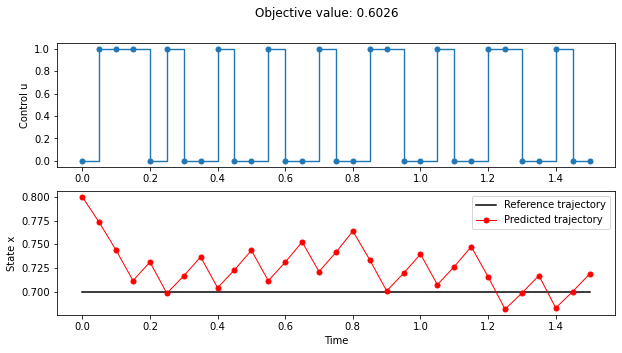

In [4]:
# Model
m = GEKKO()
m.time = np.arange(N + 1) * h

m.options.SOLVER=1  # APOPT is an MINLP solver

# optional solver settings with APOPT
m.solver_options = ['minlp_maximum_iterations 500', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 100', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 50', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 1', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.05', \
                    # covergence tolerance
                    'minlp_gap_tol 0.01']

# Manipulated variable
u = m.MV(value=0, integer=True, lb=0, ub=1, name='u')
u.STATUS = 1  # allow optimizer to change
u.DCOST = 0.0 # smooth out u movement

# Controlled Variable
x = m.CV(value=0.8, name='x')
x.STATUS = 1  # add the SP to the objective
m.options.CV_TYPE = 2 # squared error
x.SP = 0.7     # set point
x.TR_INIT = 0 # set point trajectory
# x.TAU = 5     # time constant of trajectory

# Process model
m.Equation(x.dt() == x**3 - u)

m.options.IMODE = 6 # control
m.solve(disp=False)

# get additional solution information
with open(m.path+'//results.json') as f:
    results = json.load(f)
results['obj'] = m.options.OBJFCNVAL
    
show_results(results, 'x', 'int_u')

Proposal algorithm:

MI-NL-MPC :
1. Relaxed version: NL-MPC
2. MI-QMPC (quadratic approximation of the nonlinear system)
3. 

NL-MPC:

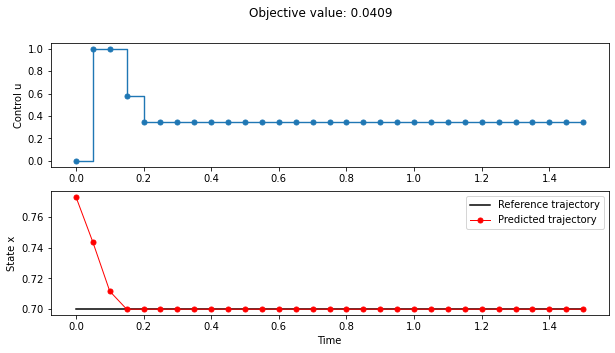

In [6]:
m.solver_options = ['minlp_maximum_iterations 500', \
                    'minlp_max_iter_with_int_sol 100', \
                    'minlp_as_nlp 1', \
                    'nlp_maximum_iterations 50', \
                    'minlp_branch_method 1', \
                    'minlp_integer_tol 0.05', \
                    'minlp_gap_tol 0.01']
m.solve(disp=False)

with open(m.path+'//results.json') as f:
    results_nl = json.load(f)
results_nl['obj'] = m.options.OBJFCNVAL
    
show_results(results_nl, 'x', 'int_u')

QMPC: